# 2b. 2-D Riemann Solvers, applied to Blast Waves

## Hydrodynamics
The equations of hydrodynamics are
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \mathsf{I}] & = 0 \\
\partial_t E + \mathbf{\nabla} \cdot [(E + P)\, \mathbf{v}] & = 0\,,
\end{align}
where $\rho$ is density, $\mathbf{v}$ is velocity, $P$ is pressure, and $E$ is the total energy density. $E = \rho e + {1 \over 2} \rho v^2$, and $e$ is the internal energy per mass. This is complemented by an equation of state $P = (\gamma - 1)\rho e$.

This can also be written in the Lagranian form
\begin{align}
\partial_t \rho & = - \mathbf{v} \cdot \mathbf{\nabla} \rho - \rho \mathbf{\nabla} \cdot \mathbf{v} \\
\partial_t \mathbf{v} & = - (\mathbf{v} \cdot \mathbf{\nabla}) \mathbf{v} - \frac{1}{\rho} \mathbf{\nabla} P  \\
\partial_t P &= - \mathbf{v} \cdot \mathbf{\nabla} P - \gamma P \mathbf{\nabla} \cdot \mathbf{v}\,,
\end{align}
where the advective derivative ($-\mathbf{v} \cdot \mathbf{\nabla}$) is explicit.

Today, we will switch to using 2-D solvers, so we can study for example _blast waves_.

### Standard libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

## Using a Python class to store things
We start by defining a class `hd`, with things we will need for 2-D hydrodynamics.  Notice how we now use Python ___classes___ to make it possible to include also _methods_ (functions, subroutines), bound to the classes. 

In [2]:
# Empty class, used to create ad hoc objects
class empty_class(): pass

class hd():
    """ Template class for hydrodynamics, with parameters, variables and methods """
    def __init__(self,n=64,gamma=1.4,Lbox=2.,cs=1):
        """ Initialization of arrays for conservative variables """
        self.n=n                    # number of points along a coordinate axis. n*n in total
        self.Lbox=Lbox              # box size
        self.t = 0                  # time
        self.it = 0                 # iterations
        self.gamma = gamma          # adiabatic index
        self.cs = cs                # sound speed only used if gas isothermal
        self.D    = np.ones((n,n))  # density
        self.Etot = np.ones((n,n))  # total energy
        self.Mx   = np.zeros((n,n)) # momentum in x-direction
        self.My   = np.zeros((n,n)) # momentum in y-direction
        self.coordinates()          # setup cooridnate system
    
    def coordinates(self):
        """ Coordinate initialization """
        n = self.n              # shorthand, used a lot below
        self.ds = self.Lbox/n
        # cell-centered coordinates are in the interval [-Lbox/2+ds/2,...,Lbox/2-ds/2]
        self.x = np.linspace(-self.Lbox*0.5,self.Lbox*0.5,num=self.n,endpoint=False)+0.5*self.ds
        self.y = self.x
        xv, yv = np.meshgrid(self.x, self.y, sparse=True) # Coordinates as 2D arrays
        self.r = (xv**2 + yv**2)**0.5           # make a 2D radius function for convenience

    def velocity(self):
        """ Compute velocity from conservative variables and return in (2,n,n) array """
        return np.array([self.Mx/self.D, self.My/self.D])

    def pressure(self):
        """ Compute pressure from conservative variables """
        if (self.gamma==1):
            P = self.cs**2 * self.D
        else:
            Eint = self.Etot - 0.5*(self.Mx**2 + self.My**2)/self.D
            P = (self.gamma-1.)*Eint
        return P

    def temperature(self):
        """ Compute the 'temperature', defined as Pressure/density = kB / mu T """
        return self.pressure() / self.D
    
    def Courant(self,Cdt=0.5):
        """ Courant condition for HD """
        v = self.velocity()
        speed = np.sqrt(v[0]**2 + v[1]**2)
        cs = np.sqrt(self.gamma*self.pressure()/self.D)
        return Cdt*self.ds/np.max(cs+speed)

## Riemann Solvers

Riemann solvers are used to compute the fluxes that pass mass, momentum, and energy from cell to cell.  When working in two dimensions, we need to treat the interfaces on all four sides of each cell, with differences between _left_ and _right_, and _bottom_ and _top_ controlling the changes of conserved quantities.

#### __Task 1: Complete the 2-D LLF and HLL solvers (20p)__
Given the description (in the comments below) of how to combine the fluxes, and what you learned in the Tuesday exercise, add the energy equation to the LLF solver, and complete the HLL Riemann solver. Notice the solver is two dimensional.

In [3]:
# Conservative variables computed from primitve variable
def primitive_to_conservative(q):
    U = empty_class()
    U.D  = q.D
    U.Mperp = q.D*q.vperp
    U.Mpar  = q.D*q.vpar
    if q.gamma!=1.0:
        U.Etot = q.P/(q.gamma-1.) + 0.5*q.D*(q.vperp)**2 + 0.5*q.D*(q.vpar)**2
    return U

# Hydro flux from conservative and primitive variables
# The flux through the interface is carried by the perpendicular velocity
def Hydro_Flux(q,U):
    F = empty_class()
    F.D = U.Mperp
    F.Mperp = U.Mperp*q.vperp + q.P
    F.Mpar  = U.Mpar *q.vperp
    if q.gamma!=1.0:
        F.Etot = (U.Etot + q.P) *(q.vperp)
    return F

### LLF fluxes
LLF is the most diffuse Riemann solver. But also the most stable.

In [4]:
def LLF(ql,qr):
    # sound speed for each side of interface (l==left, r==right)
    c_left  = (ql.gamma*ql.P/ql.D)**0.5
    c_right = (qr.gamma*qr.P/qr.D)**0.5
    c_max = np.maximum (c_left, c_right)
    
    # maximum propagation speed anywhere
    cmax = np.maximum(np.abs(ql.vperp)+c_max, np.abs(qr.vperp)+c_max)

    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    # LLF flux based on maximum wavespeed.
    # The general form is 
    #   (F_left + F_right - cmax*(U_right - U_left)) / 2
    # where U = (rho, rho*vperp, rho*vpar, E_tot) are the conserved variables
    Flux = empty_class()
    Flux.D  = 0.5*(Fl.D  + Fr.D  - cmax*(Ur.D  - Ul.D))
    Flux.Mperp = 0.5*(Fl.Mperp + Fr.Mperp - cmax*(Ur.Mperp - Ul.Mperp))
    Flux.Mpar  = 0.5*(Fl.Mpar  + Fr.Mpar  - cmax*(Ur.Mpar  - Ul.Mpar ))
    if ql.gamma!=1.0:
        Flux.Etot = 0.5*(Fl.Etot + Fr.Etot - cmax*(Ur.Etot - Ul.Etot))
    
    return Flux

### HLL (Harten, Lax, van Leer) fluxes
This is a bit less diffuse.  The first part is identical to the LFF solver, and only the method to combine the left and right fluxes at the interfaces differ. 

In [5]:
def HLL(ql,qr):
    # sound speed for each side of interface (l==left, r==right), and maxmimum sound speed (c_max)
    c_left  = (ql.gamma*ql.P/ql.D)**0.5
    c_right = (qr.gamma*qr.P/qr.D)**0.5
    c_max = np.maximum (c_left, c_right)

    # maximum wave speeds to the left and right (guaranteed to have correct sign)
    SL = np.minimum(np.minimum(ql.vperp,qr.vperp)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.vperp,qr.vperp)+c_max,0) # >= 0.

  # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)
    
    # HLL flux based on wavespeeds. If SL < 0 and SR > 0 then mix state appropriately
    # The general form is 
    #    (SR * F_left - SL * F_right + SL * SR *(U_right - U_left)) / (SR - SL)
    # where U is the state vector of the conserved variables
    Flux = empty_class()
    Flux.D = (SR*Fl.D - SL*Fr.D + SL*SR*(Ur.D - Ul.D)) / (SR - SL)
    Flux.Mperp = (SR*Fl.Mperp - SL*Fr.Mperp + SL*SR*(Ur.Mperp - Ul.Mperp)) / (SR - SL)
    Flux.Mpar  = (SR*Fl.Mpar  - SL*Fr.Mpar  + SL*SR*(Ur.Mpar  - Ul.Mpar )) / (SR - SL)
    if ql.gamma != 1:
       Flux.Etot = (SR*Fl.Etot - SL*Fr.Etot + SL*SR*(Ur.Etot - Ul.Etot)) / (SR - SL)
    return Flux

### Slope limiter
Monotonized Central (MonCen) slope limiter.  In two dimensions, return the  slopes in both directions, with shape (2,n,n)

In [6]:
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

def MonCen(f):
    """ Monotonized central slope limiter """
    shape=np.insert(f.shape,0,f.ndim)
    slopes=np.empty(shape)
    for i in range(f.ndim):
        ls=left_slope(f,axis=i)
        rs=np.roll(ls,-1,axis=i)
        cs=np.zeros_like(f)
        w=ls*rs>0
        cs[w]=2*ls[w]*rs[w]/(ls[w]+rs[w])
        slopes[i]=cs
    if f.ndim==1:
        return cs
    else:
        return slopes

### MUSCL Method for time updates in two dimensions
To simplfy the equations we write the system in vector notation, with a _state vector_ $U$, and a _flux vector_ $F$, and assume we have two dimensions. $u$ is the velocity in the $x$-direction, $v$ is the velocity in the $y$-direction. Then for the flux along the first dimension we have
\begin{align}
U &= (\rho, \rho u, \rho v) \\
F_x &= (\rho u, \rho u u + P, \rho v u) \\
\partial_t U + \partial_x F_x & = 0
\end{align}

From last week's lecture slide we have the __master equation__ for solving the system along one coordinate axis:
\begin{equation}
U(t + \Delta t,x_{i-1/2}) - U(t,x_{i-1/2}) = - \frac{\Delta t}{\Delta x} \left[ \tilde F_x(t + {\Delta t \over 2},x_{i}) - \tilde F_x(t + {\Delta t \over 2},x_{i-1}) \right]\,,
\end{equation}
where the flux terms are integrals over the time step and the cell faces (that in 1D is just a point, but in 2D a line, and in 3D an area)
\begin{equation}
\tilde F_x(t + {\Delta t \over 2},x_{i}) = {1 \over \Delta t}
\int^{t + \Delta t}_t \textrm{d} t' F_x(t', U_I(t',x_i))\,,
\end{equation}
and $U_I$ are the point values of $U$ at the interface.

The 2D MUSCL method improves on Godunov method by approximating the time integral and assuming that we can make a slope interpolation for the values at the interface.
The alogrithm goes as follows
  1. From the state vector $U$ compute the _primitive_ variables q = ($\rho$,$v$,$P$)
  2. Compute the spatial slopes from center of cell to interface. Making the slopes monotonized (TVD) if needed. The slope accross a cell are $\Delta q_x$ and $\Delta q_y$.
  3. Compute a naive time evolution for the primitve variables at the center of the cell using an Euler step and the Lagranian hydro equations. E.g.
\begin{equation}
\Delta q_t = \Delta t \frac{\textrm{d}q}{\textrm{d}t}
\end{equation}

Step 4 to 7 have to be done first in the $x$-direction and then in the $y$-direction

  4. Approximate $q(t+\Delta/2, (x,y)\pm\Delta s/2) = q(t,x,y) + (\Delta q_t \pm \Delta q_s) / 2$ where $s$ is either the $x$ or $y$ direction
  5. Shift point of view from cells to interfaces and consider fluid variables on the _left_ and _right_ sides of _interfaces_.
  6. Use an (approximate) Riemann solver to compute the fluxes. If considering the $y$-direction permute coordinate directions to make it the primary direction (which is what the Riemann solver expects).
  7. Update the state vector based on the fluxes. Fluxes have to be inversely permuted if necessary.

Below is the code corresponding to the algorithm. 

In [7]:
# from numba import jit

# @jit(nopython=True)
def muscl_2d (exp, dt, Slope=MonCen, Riemann_Solver=LLF):
    ds   = exp.ds
    ids  = 1. / exp.ds # 1 / cell size, useful for derivatives below
    dtds = dt/exp.ds

    # 1) Compute primitive variables (D, v, P)
    # make sure to copy exp.D to D, otherwise D becomes a "pointer" to exp.D, and updates itself in 7)
    D = np.copy(exp.D)         # D: density (n,n)
    v = exp.velocity()         # v: velocity (2,n,n)
    P = exp.pressure()         # P: pressure (n,n)

    # 2) Compute slope limited derivatives based on centered points
    dD = Slope(D) * ids        # returns (2,n,n)
    dP = Slope(P) * ids        # returns (2,n,n)
    dv0 = Slope(v[0]) * ids    # returns (2,n,n)
    dv1 = Slope(v[1]) * ids    # returns (2,n,n)
    dv = np.array([dv0,dv1])   # shape = (2,2,n,n)

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    
    # Time evolution with source terms
    div = dv[0,0] + dv[1,1]                  # div(v)
    D_t = - v[0]*dD[0] - v[1]*dD[1] - D*div  # dD/dt = -v*grad(D) - D*div(v)
    P_t = - v[0]*dP[0] - v[1]*dP[1] - exp.gamma*P*div # dP/dt = -v*grad(P) - gamma*P*div(v)
    v_t = np.empty_like(v)                   # create empty array with shape = (2,n,n)
    v_t[0] = - v[0]*dv[0,0] - v[1]*dv[0,1] - dP[0]/D  # dv/dt = -v*grad(v) - grad(P)/D
    v_t[1] = - v[0]*dv[1,0] - v[1]*dv[1,1] - dP[1]/D
    
    # Loop over X- and Y-direction
    for axis in range(2):
        ql = empty_class(); ql.gamma = exp.gamma
        qr = empty_class(); qr.gamma = exp.gamma
        
        # Calculates the perpendicular and parallel velocities to the interface
        # X-axis: iperp=0, ipar=1, Y-axis: iperp=1, ipar=0
        iperp = axis
        ipar  = (axis + 1) % 2
        # Perpendicular and parallel velocities
        vperp = v[iperp]; dvperp = dv[iperp]; vperp_t = v_t[iperp]
        vpar  = v[ipar];  dvpar  = dv[ipar];  vpar_t  = v_t[ipar]

        # 4) Spatial interpolation "axis"-direction + time terms

        # left state -- AS SEEN FROM THE INTERFACE
        ql.D = D + 0.5*(dt*D_t + ds*dD[axis])
        ql.P = P + 0.5*(dt*P_t + ds*dP[axis]) 
        ql.vperp = vperp + 0.5*(dt*vperp_t + ds*dvperp[axis])
        ql.vpar  = vpar  + 0.5*(dt*vpar_t  + ds*dvpar[axis])

        # right state -- AS SEEN FROM THE INTERFACE
        qr.D = D + 0.5*(dt*D_t - ds*dD[axis])
        qr.P = P + 0.5*(dt*P_t - ds*dP[axis])
        qr.vperp = vperp + 0.5*(dt*vperp_t - ds*dvperp[axis])
        qr.vpar  = vpar  + 0.5*(dt*vpar_t  - ds*dvpar[axis])

        # 5) Roll down -1 in the "axis" direction so that we collect
        #    left and right state (as seen from the interface) at the same grid index
        qr.D = np.roll(qr.D,-1,axis=axis)
        qr.P = np.roll(qr.P,-1,axis=axis)
        qr.vperp = np.roll(qr.vperp,-1,axis=axis)
        qr.vpar  = np.roll(qr.vpar, -1,axis=axis)

        # 6) Solve for flux based on interface values
        Flux = Riemann_Solver(ql,qr)

        # 7) Update conserved variables with fluxes
        exp.D  -= dtds * (Flux.D - np.roll(Flux.D,1,axis=axis))
        if exp.gamma != 1:
            exp.Etot -= dtds * (Flux.Etot - np.roll(Flux.Etot,1,axis=axis))
        if axis==0: # X-axis
            exp.Mx   -= dtds * (Flux.Mperp - np.roll(Flux.Mperp,1,axis=axis))
            exp.My   -= dtds * (Flux.Mpar  - np.roll(Flux.Mpar, 1,axis=axis))
        if axis==1: # Y-axis
            exp.My   -= dtds * (Flux.Mperp - np.roll(Flux.Mperp,1,axis=axis))
            exp.Mx   -= dtds * (Flux.Mpar  - np.roll(Flux.Mpar, 1,axis=axis))

    exp.t  += dt # update time
    exp.it += 1  # update number of iterations

    return exp

# Blast Wave in 2-D

Releasing a large amount of energy into a background fluid creates an explosion characterized by a strong shock wave, which then expands radially outwards from the point where the energy was released. In astrophysics, this happens, for example, in the case of supernovae.

This is called a Sedov-Taylor blast wave. Sedov and Taylor first solved the problem in the context of atomic bomb explosions, but the solution is also useful in astrophysics. It can be used to test and validate hydrodynamical computer codes since an analytical solution exists. Blast waves are good candidates for adaptive mesh refinement (AMR) technique, that you read about in the book, but they can also be resolved with a uniform grid that we will use in this exercise.

#### __Task 2: Add a profile that defines the blast (10p)__

Complete the blast wave setup with an initial profile for the total energy, of the form

\begin{equation}\tag{2}
f(r) = 1 + e0 \, B \, e^{-\left(\frac{r}{w\Delta r}\right)^p}
\end{equation}

where $p$ is an exponent of order $2-4$, and $w$ controls the with in cell size ($\Delta r$) units.  In the code, use `e0` for the total energy. The factor $B$ is there to normalize the total energy to be the same no matter what is chosen for $w$ and $p$. E.g. $B$ should be chosen such that
\begin{equation}
\int dV B \, e^{-\left(\frac{r}{w\Delta r}\right)^p} = \sum B \, \Delta x \Delta y \, e^{-\left(\frac{r}{w\Delta r}\right)^p} = 1
\end{equation}

In [17]:
class blast_wave(hd):
    """ An extension of the hd() class with initial conditions """
    def __init__(exp,n=64,gamma=1.4,e0=1e3,d0=0.0,power=2,w=3.,eps=0.05):
        hd.__init__(exp,n)
        exp.gamma = gamma
        exp.D  = np.ones((n,n))

        
        dr = exp.ds
        r = exp.r
        profile = e0*np.exp(-np.power(r/(w*dr),power))
        B = np.sum(profile)*dr*dr
        exp.Etot = np.ones((n,n)) + profile / B

We want the $y$ coordinate increasing upwards in image plots, so we define a variant of `imshow` (change default `size` according to taste):

In [18]:
def imshow(f,size=10,axis=None):
    plt.figure(figsize=(size,size))
    if axis is None:
        extent = None
    else:
        extent = ([axis.min(), axis.max(), axis.min(), axis.max()])

    plt.imshow(np.transpose(f),origin='lower',extent=extent)
    plt.colorbar()
    
def title(e0=1e5,d0=1.0,C=0.5,n=128,solver=HLL):
    plt.title('e0={:.0e}   d0={:.0e}   C={:.1f}  n={}  {}'.format(e0,d0,C,n,solver.__name__));

Try it out on the initial condition:

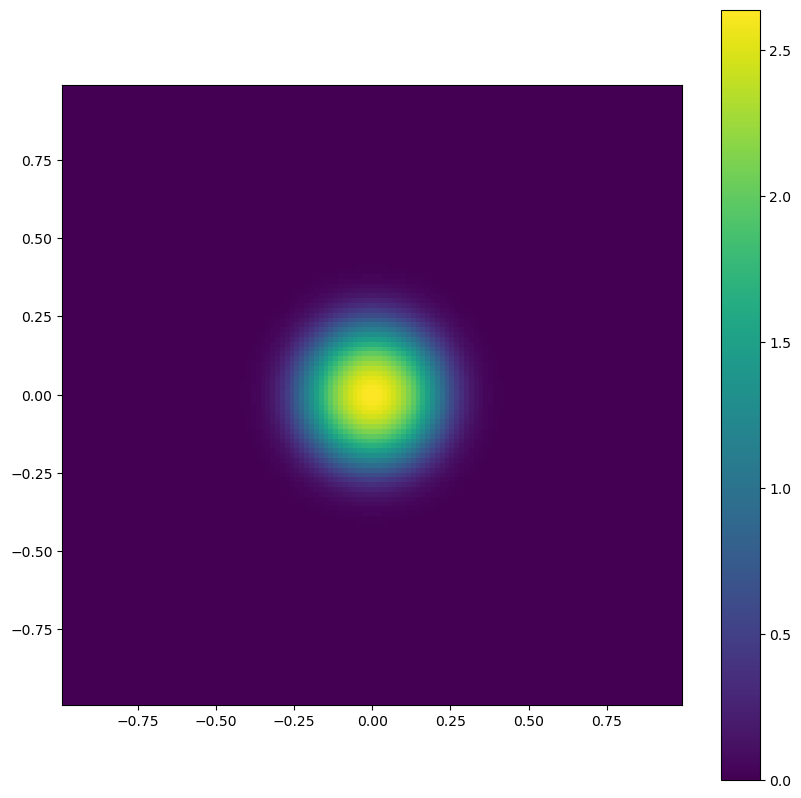

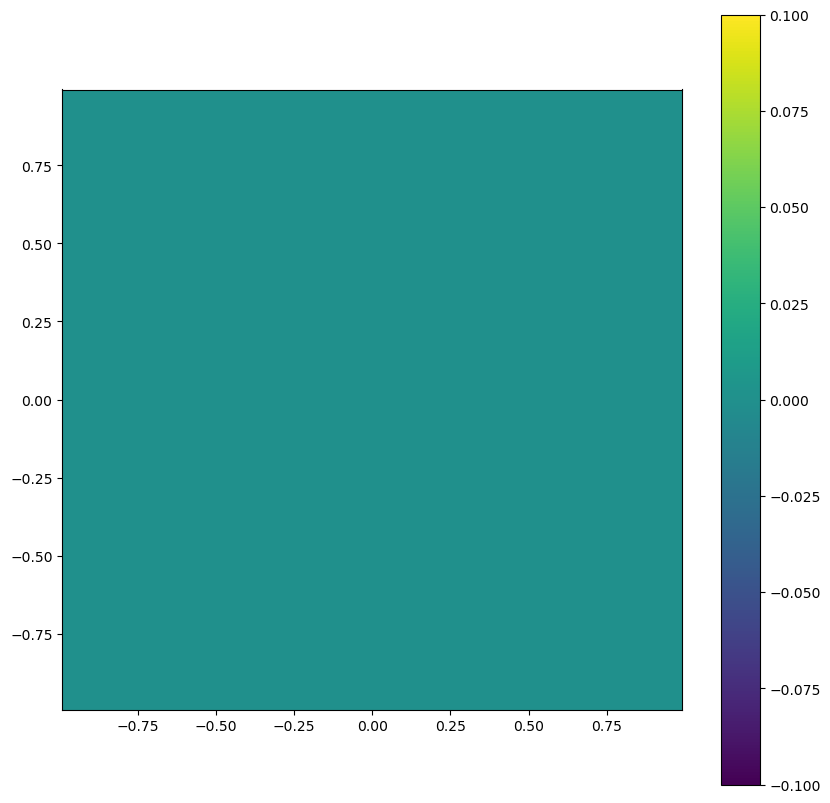

In [19]:
exp = blast_wave(n=128,w=10)
imshow(np.log(exp.Etot),axis=exp.x)
imshow(np.log(exp.D),axis=exp.x)

#### __Task 3: Scaling relations (20p)__

Even without the exact analytical solution, one can already test the correctness using the scaling behaviour of the expanding shock.

The radius of an expanding 3-D blast wave in a homogeneous medium scales as

\begin{equation}\tag{1}
R \sim E^{1/5} \rho^{-1/5} t^{2/5}
\end{equation}

We would like to test if we can reproduce the scaling of the shock radius. To do this, run the eperiment, and figure out a way to track the radius as a function of time (search for a suitable maximum as a function of distance from the center). Does it match the expectation, or else how does it scale with time? Produce a plot of the shock radius as a function of time. Check in the output PDFs that the printout actually matches the edge of the shock and that the maximum of the density is not at some other place.

The dimensional analysis assumes a blast wave expanding in a three dimensional medium with a density having dimensions $\rho \sim M/L^3$. But we are running in two dimensions. Derive the scaling law for two dimensions by figuring out the unique combination of time ($t$), density ($\Sigma = M/L^2$), and energy ($M L^2 / S^2$) that gives the appropriate length scale. Does this now match with the shock radius observed in the simulation?

M => a + b = 0   ->  a = -b  -> -1/4
L = 2b - 2a = 1  -> 4b = 1 -> b = 1/4 
-2b + c = 0      -> c = 1/2

### A small Blast Wave example

This should take about 3 seconds:

23.0 sec, 4.69 microseconds/update


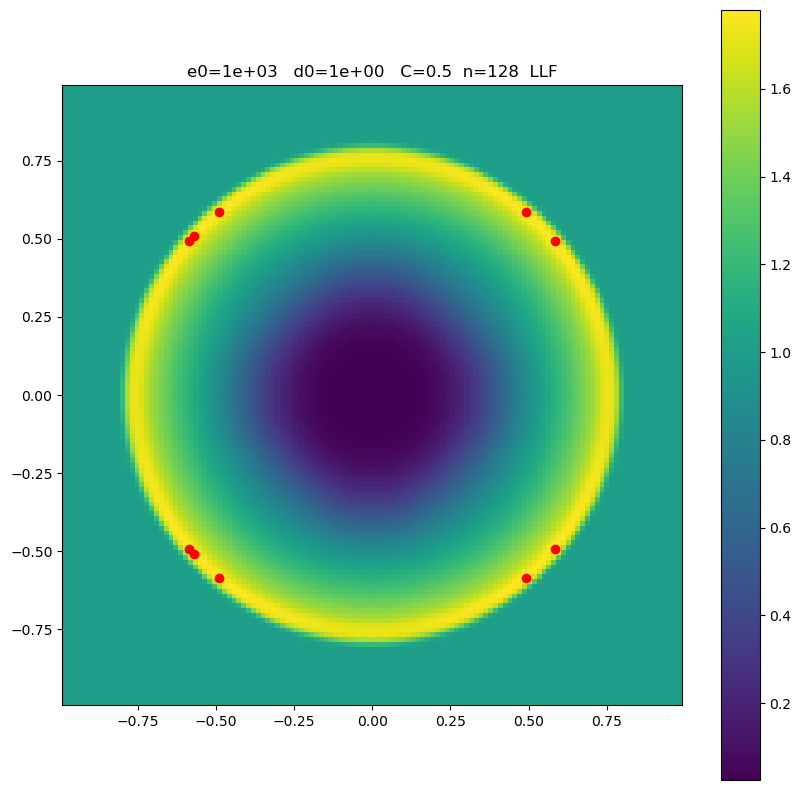

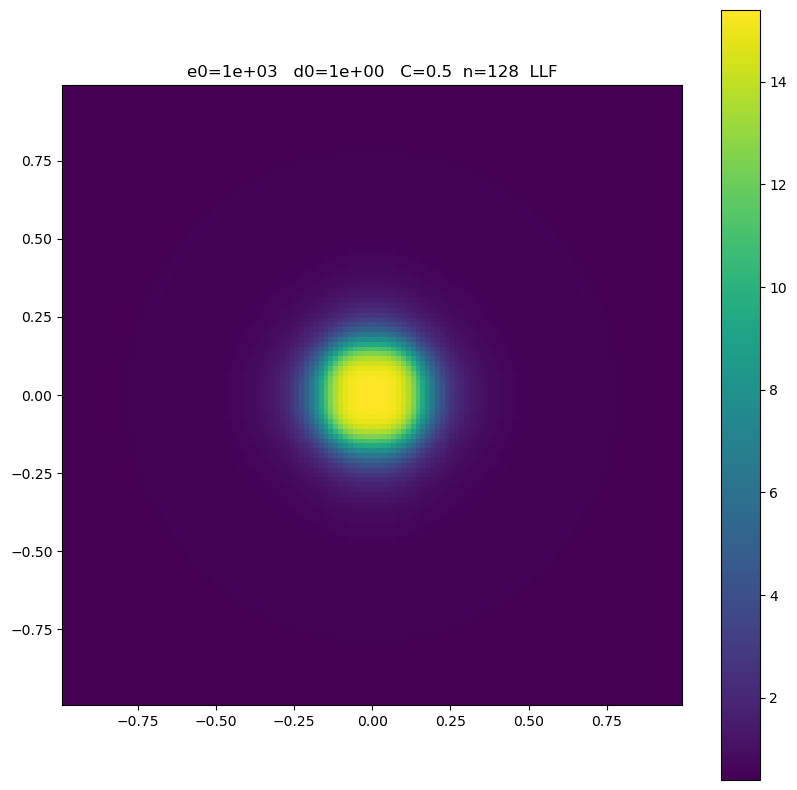

In [62]:
e0 = 1e3
n = 128
Cdt = 0.5
nt = 300
solver = LLF
exp = blast_wave(n=n,e0=e0,gamma=1.4,w=3.,power=4,eps=0.1)
start = time()

dists = []
Ts = []
T = 0
for it in range(nt):
    dt=exp.Courant(Cdt)
    exp = muscl_2d(exp,dt,Slope=MonCen, Riemann_Solver=solver)

    # top_D = np.argsort(exp.D, axis = 0)[-10:]
    top = np.dstack(np.unravel_index(np.argsort(exp.D.ravel()), (n, n)))

    top = top[0][-10:]
    top_possx, top_possy = exp.x[top[:,0]], exp.y[top[:,1]]

    dists.append(np.array([np.sqrt(top_possx[i]**2 + top_possy[i]**2) for i in range(len(top_possx))] ))
    T += dt
    Ts.append(T)


used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
imshow(exp.D,axis=exp.x)
plt.plot(top_possx, top_possy, 'ro')
title(e0=e0,C=Cdt,n=n,solver=solver)
imshow(exp.temperature(),axis=exp.x)
title(e0=e0,C=Cdt,n=n,solver=solver)

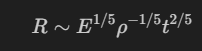

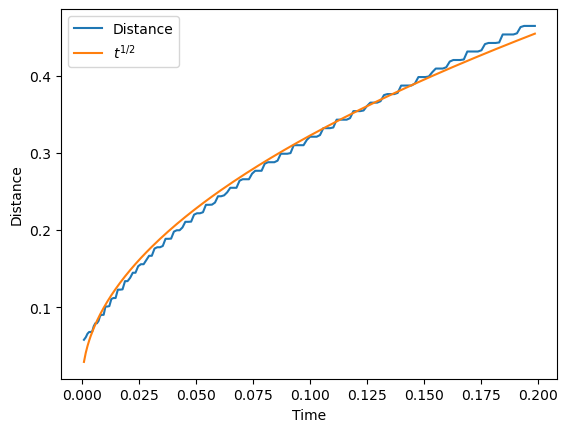

In [66]:
dists = np.array(dists)

check_part = 150

plt.plot(Ts[:check_part], dists.mean(axis = 1)[:check_part], label = 'Distance')
plt.plot(Ts[:check_part], np.power(Ts[:check_part], 1/2)*1.02, label = '$t^{1/2}$')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()

You may want to use this cheap setup to explore the effect of for example making the width $w$ smaller

### A Blast Wave example, with tendencies for instabilities

Define a new function that runs an experiment with a given solver and resolution and makes a few plots. Notice how you may give the keyword `tend` to run the experiment until an exact time.

In [30]:
def example(exp = None, n=400,nt=-1,solver=HLL,d0=0.,e0=1e3,w=3.,tend=None):
    Cdt = 0.5
    if nt==-1:
        nt = n
    estimate=6.*(n/200.)**3 * nt / n
    if estimate>9.9:
        print("this will take approx {:.0f} seconds".format(estimate))
    if exp is None:
        exp = blast_wave(n=n,d0=d0,e0=e0,gamma=1.4,w=w,power=4)
    start = time()
    if tend is None:
        while exp.it < nt:
            dt=exp.Courant(Cdt)
            exp = muscl_2d(exp,dt,Slope=MonCen,Riemann_Solver=solver)
    else:
        # add and extra condition of max 10.000 iterations in case
        # hydrodynamics crashes and timestep goes to zero
        while exp.t < tend and exp.it < 1e4:
            dt = exp.Courant(Cdt)
            dt = min(dt, tend - exp.t) # make last timestep exactly reach tend
            exp = muscl_2d(exp,dt,Slope=MonCen,Riemann_Solver=solver)
            print(exp.t/tend)

    used=time()-start
    print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*nt)))
    if tend is None:
        print('End time :', exp.t)

    imshow(exp.D,axis=exp.x)
    title(e0=e0,d0=d0,C=Cdt,n=n,solver=solver)
    imshow(exp.temperature(),axis=exp.x)
    title(e0=e0,d0=d0,C=Cdt,n=n,solver=solver)

    return exp

Run two quick experiments with LLF and HLL solvers. Notice, by plotting e.g. the density, how LLF is more diffusive than HLL.

1.5 sec, 0.72 microseconds/update
End time : 0.16420015124752313


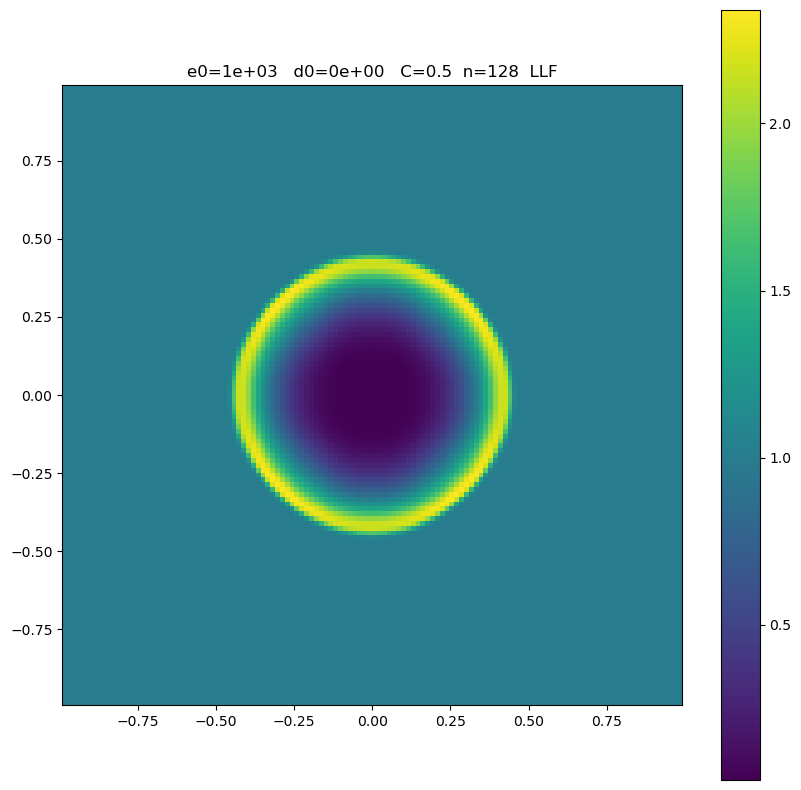

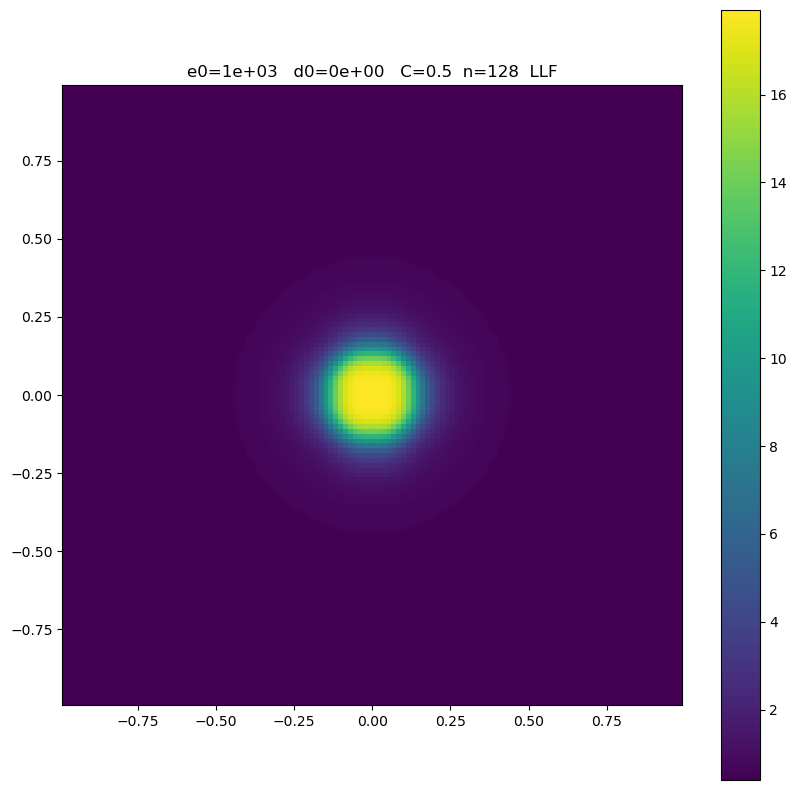

In [23]:
exp1=example(n=128,solver=LLF)

1.7 sec, 0.81 microseconds/update
End time : 0.1607443671627107


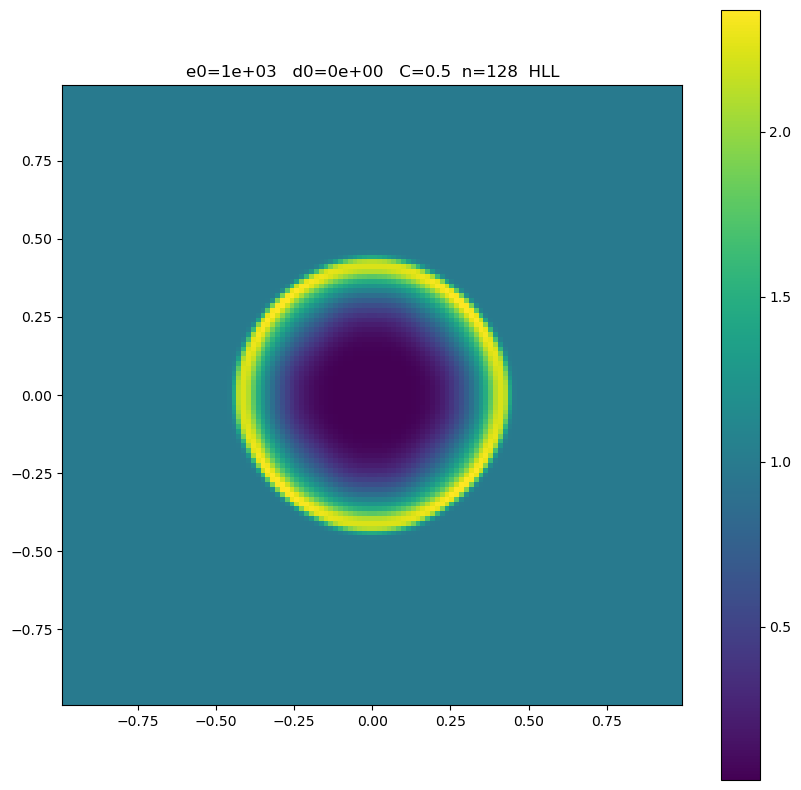

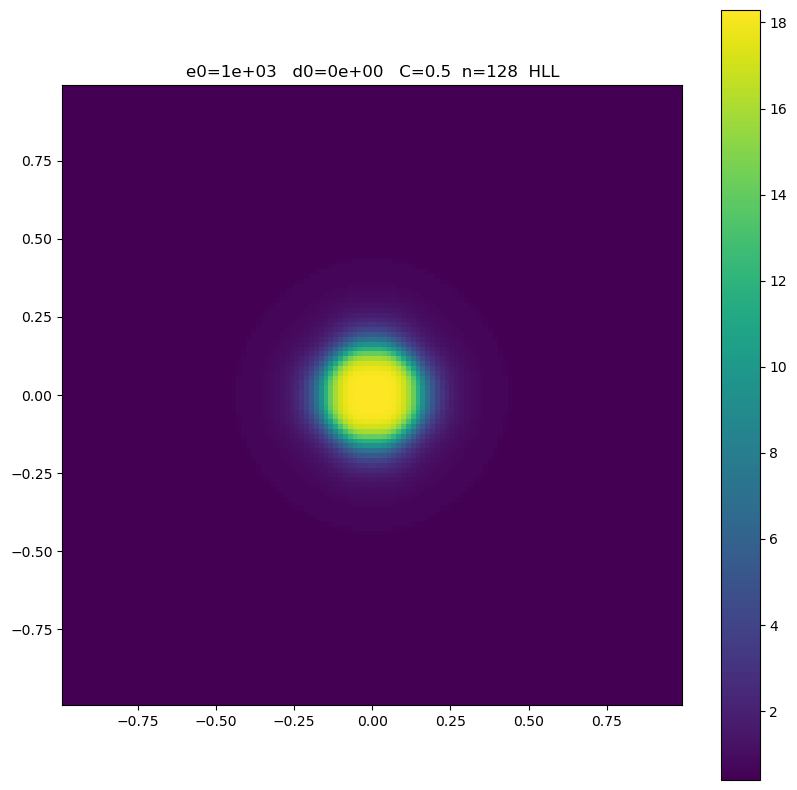

In [24]:
exp2=example(n=128,solver=HLL)

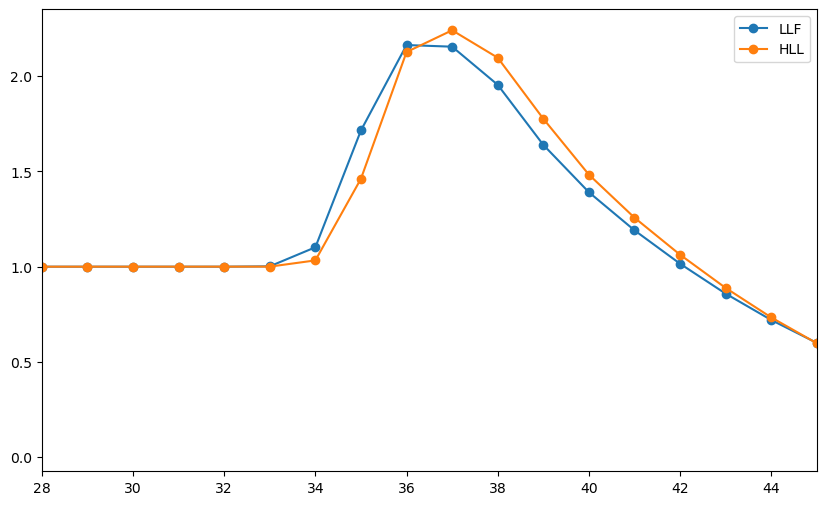

In [25]:
plt.figure(figsize=(10,6))
plt.plot(exp1.D[:,exp1.n//2],'-o',label='LLF')
plt.plot(exp2.D[:,exp2.n//2],'-o',label='HLL')
plt.legend()
plt.xlim(28,45);

To explore the substructure in the blast wave, we need higher resolution. This example should take about 20 seconds to run, and produce a thinner shock front:

this will take approx 20 seconds
22.2 sec, 0.82 microseconds/update
End time : 0.08267845504699352


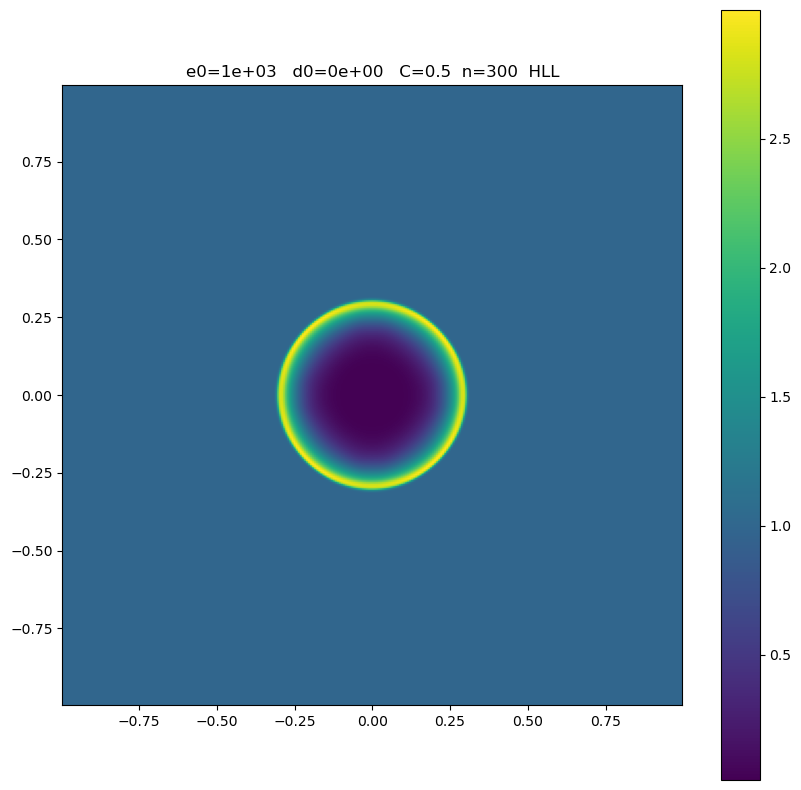

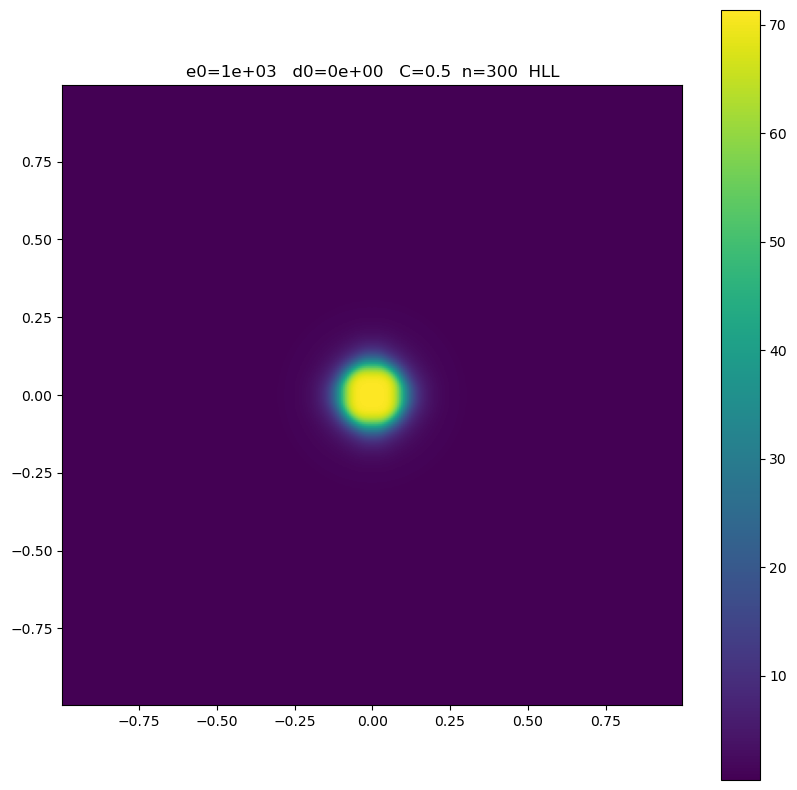

In [26]:
exp=example(n=300,solver=HLL)

#### __Task 4: Rayleigh-Taylor instabilities in blast waves (30p)__

A supernova exploding in the interstellar medium does not only have a high pressure, it also contains a significant amount of mass. To simulate this, try adding mass to your experiment, by using a similar profile for density, with `m0` being the total mass in the profile.

Add mass by setting `m0` to something similar to the box mass, eg. 0.5, corresponding to a dense and warm source of the blast. Run the simulation followed by the analysis again. What is the impact of adding mass? How does the expansion change? How does the radius as a function of time change? What about the structure of the shock: Does it look similar to what you saw in the first run? If not, why not?

And: Can you make significant Rayleigh-Taylor instabilities develop, by tuning the parameters (include increasing `n`)?  Note that when you change `n` it is useful to set `tend`, to get to the same radius, so the cost (wall clock time) increases with a factor of 8, for each power of 2 (note that it is not necessary to use powers of 2). It may help to add a bit of random noise with amplitude `eps` to e.g. the density profile, to seed the perturbations (what is seeding the perturbations without the noise?).


In [27]:
class blast_wave_w_mass(hd):
    """ An extension of the hd() class with initial conditions """
    def __init__(exp,n=64,gamma=1.4,e0=1e3,d0=0.5,power=2,w=3.,eps=0.05):
        hd.__init__(exp,n)
        exp.gamma = gamma
        exp.D  = np.ones((n,n))

        
        dr = exp.ds
        r = exp.r
        profile = e0*np.exp(-np.power(r/(w*dr),power))
        B = np.sum(profile)*dr*dr
        exp.Etot = np.ones((n,n)) + profile / B

        mass_profile = d0*np.exp(-np.power(r/(w*dr),power))
        mass_B = np.sum(mass_profile)*dr*dr
        exp.D = np.ones((n,n)) + mass_profile / mass_B

        # add random noise to the density
        exp.D *= 1 + eps*np.random.normal(size=(n,n))
        

this will take approx 384 seconds
0.0018336364764660505
0.0036789993297326588
0.005392387016290079
0.007004950612052869
0.008529804080905439
0.009983233394090369
0.011377500149953212
0.012722652965095949
0.014025059064202252
0.015287994533153618
0.016516824953598866
0.017714530047039323
0.018885163675781497
0.020030945147030178
0.02115385633525212
0.022256962462507784
0.023341375667482952
0.02440942258008927
0.025462208083100197
0.026501282695218387
0.0275277484146056
0.0285417672607384
0.029542361982968463
0.030531749758695204
0.03150890477422639
0.03247696433510229
0.03343342277862549
0.034380403725888915
0.03531589414948005
0.03624278360642624
0.03716038807015619
0.03806884418984611
0.03896858456204226
0.03986211730158095
0.04074783548151217
0.04162617618339192
0.042498505803513664
0.04336559638914679
0.04422695631442601
0.04508248281168906
0.04593398858503964
0.046780942263605185
0.047623297813104745
0.048462066017456715
0.04929669550392478
0.05012805507827776
0.05095569563906813
0

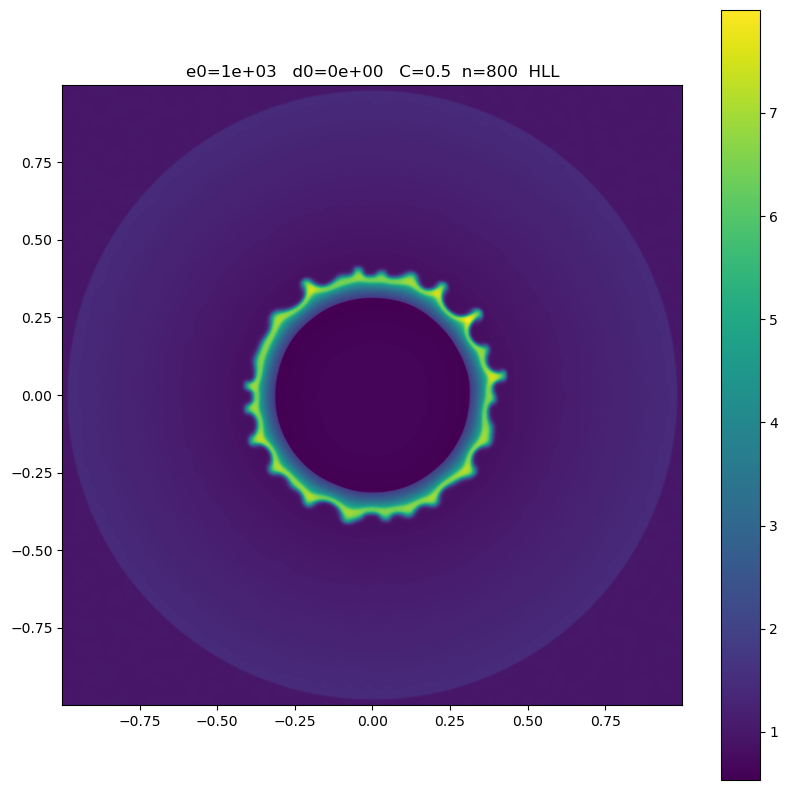

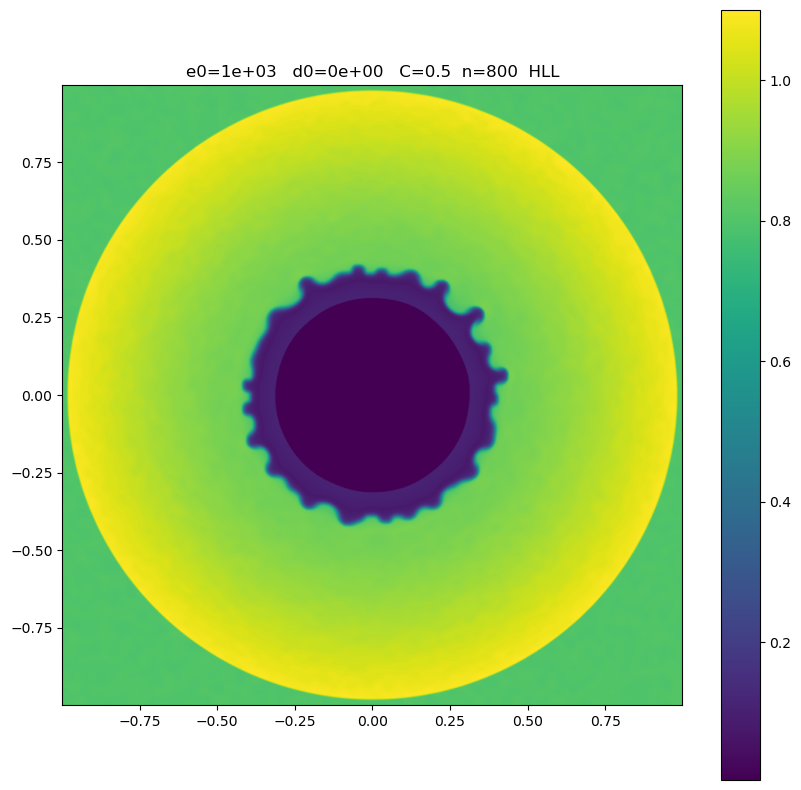

In [32]:
exp = blast_wave_w_mass(n=800,w=10, d0 = 0.5, gamma = 1.8)
example(exp, n=800, solver=HLL, tend=0.5)
# imshow(np.log(exp.Etot),axis=exp.x)
# imshow(np.log(exp.D),axis=exp.x)
# exp = blast_wave(n=128,w=10)
# example(exp, n=128, solver=HLL)
# exp = blast_wave(n=128,w=10)
# imshow(np.log(exp.Etot),axis=exp.x)
# imshow(np.log(exp.D),axis=exp.x)

#### Extra Tasks (and extra points!) for the interested

If you want to have fun with blast waves, you can extend the setup to include several blastwaves, or include areas in your "ISM" that have different density.

  * What happens if your blastwave collide with another one
  * What happens if a blastwave explodes outside a "cloud" (e.g. a dense circular region)
  * What happens if it explodes on the edge, or inside?
  
What do you learn from your experiments about the effect of feedback from Supernovae in the ISM?

0.005585756835352641
0.011165291034920803
0.016711191683241578
0.022212510133152164
0.02767140151251641
0.033081628318839304
0.038445494697964586
0.043770269170565985
0.04905713440818847
0.05431375740079885
0.05954378576949084
0.06475376409954213
0.06994887558699088
0.0751317712047352
0.0803106134031131
0.08548467317163769
0.09066075052105664
0.09584243461706457
0.10102987514204682
0.10622961794148758
0.11144377375181018
0.11667289519450756
0.12192174900015393
0.1271926589051911
0.13248723335506896
0.13780700322379602
0.1431554711675281
0.14853289307218892
0.15394263137882486
0.15938678976229367
0.16486558734914222
0.17038026856387786
0.17593338306251544
0.18152717335783086
0.18716361685896682
0.19284310114378267
0.19856643122823747
0.20433488862875068
0.2101501178821042
0.21601361571548358
0.2219267551666289
0.2278902910530112
0.23390485876333508
0.23997171173218695
0.24609203477477143
0.2522669539010252
0.25849754526134333
0.26478484272112535
0.271129439012092
0.2775320009867719
0.28

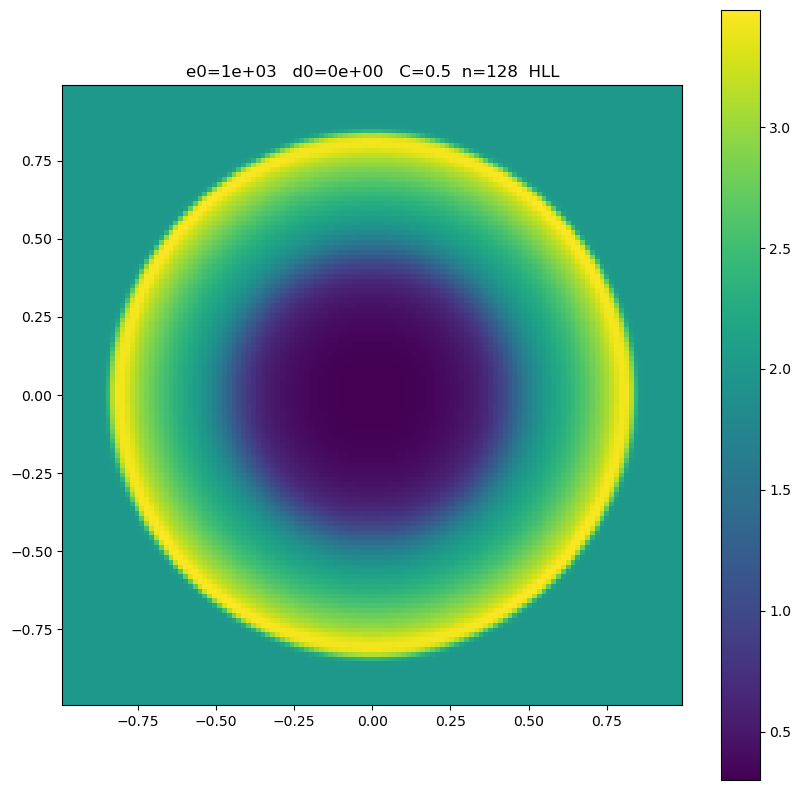

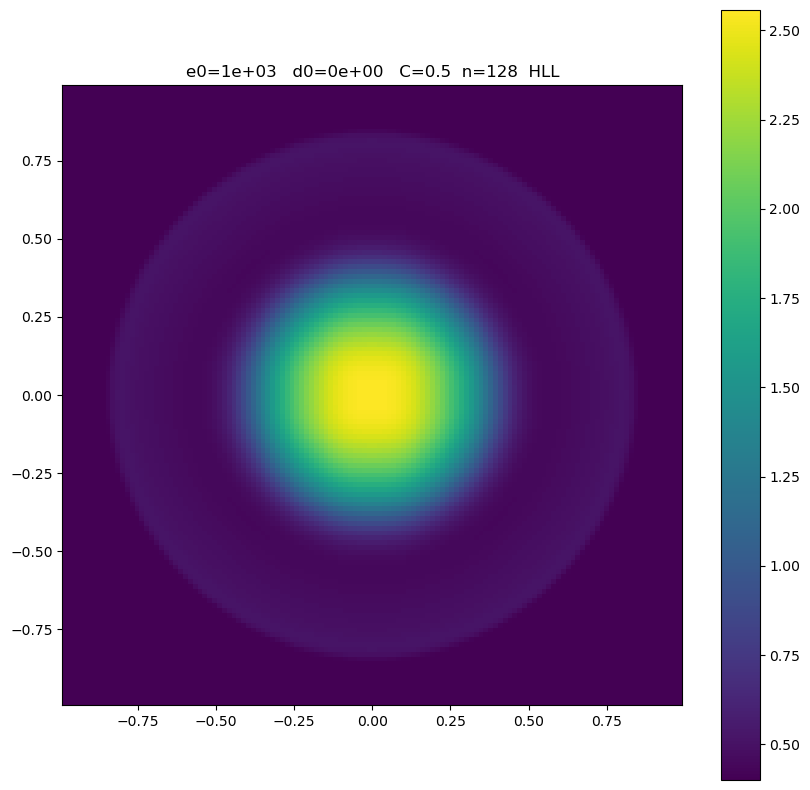

In [40]:
# make two blast waves collide

exp1 = blast_wave_2(n=128,w=10)
exp2 = blast_wave(n=128,w=10)
exp2.x += 0.2

exp_tot = exp1
exp_tot.D = exp1.D + exp2.D
exp_tot.Etot = exp1.Etot + exp2.Etot
exp_tot.Mx = exp1.Mx + exp2.Mx
exp_tot.My = exp1.My + exp2.My

example(exp_tot, n=128, solver=HLL, tend=0.5)

### __Absalon turn-in__

Upload a max 3 page report (max 4 pages if you go for the extra tasks), the notebook and a PDF of the notebook, with the coding tasks completed. You can also upload movies. Please include comments and figures in the report. 